## Brainpainter latent trajectory

Draw a trajectory over the latent space with a set of parameters and translate it to a BrainPainter ready file in order
to visualize it

In [1]:
#Import
# working dir
%cd /homedtic/gmarti/CODE/RNN-VAE/

# Imports
import sys
sys.path.insert(0, '/homedtic/gmarti/CODE/RNN-VAE/')
from rnnvae.utils import open_MRI_data_var, open_MRI_data
from rnnvae import rnnvae
from rnnvae.plot import plot_losses, plot_trajectory, plot_total_loss, plot_z_2d, plot_z_time_2d
import os
import math
from rnnvae.data_gen import SinDataGenerator
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import torch

%matplotlib inline

/homedtic/gmarti/CODE/RNN-VAE


Load the model from the experiment and directory we want

In [2]:
# DEVICE
## Decidint on device on device.
DEVICE_ID = 0
DEVICE = torch.device('cuda:' + str(DEVICE_ID) if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.cuda.set_device(DEVICE_ID)

out_dir = "experiments/meta_mri_noicv/_h_40_z_7_hid_40_l_1/"

#load parameters
p = eval(open(out_dir + "params.txt").read())

p['x_size'] = 40

model = rnnvae.ModelRNNVAE(p["x_size"], p["h_size"], p["hidden"], p["n_layers"], 
                        p["hidden"], p["n_layers"], p["hidden"],
                        p["n_layers"], p["z_dim"], p["hidden"], p["n_layers"],
                        p["clip"], p["n_epochs"], p["batch_size"], DEVICE)
model.load(out_dir+'model.pt')
model = model.to(DEVICE)

Load the data

In [62]:
csv_path = "data/tadpole_mrionly.csv"
X_train, X_test, Y_train, Y_test, mri_col = open_MRI_data_var(csv_path, train_set=0.9, normalize=True, return_covariates=True)

nfeatures = X_train[0].shape[1]

# Apply padding to both X_train and X_val
X_train_tensor = [ torch.FloatTensor(t) for t in X_train ]
X_train_pad = torch.nn.utils.rnn.pad_sequence(X_train_tensor, batch_first=False, padding_value=np.nan)
X_test_tensor = [ torch.FloatTensor(t) for t in X_test ]
X_test_pad = torch.nn.utils.rnn.pad_sequence(X_test_tensor, batch_first=False, padding_value=np.nan)

p["ntp"] = max(X_train_pad.size(0), X_test_pad.size(0))

# Those datasets are of size [Tmax, Batch_size, nfeatures]
mask_train = ~torch.isnan(X_train_pad)
mask_test = ~torch.isnan(X_test_pad)

#convert those NaN to zeros
X_train_pad[torch.isnan(X_train_pad)] = 0
X_test_pad[torch.isnan(X_test_pad)] = 0

max_timepoints = X_train_pad.shape[0]
# Those datasets are of size [Tmax, Batch_size, nfeatures]
# Predict the reconstructions from X_val and X_train
X_test_fwd = model.predict(X_test_pad.to(DEVICE))
X_train_fwd = model.predict(X_train_pad.to(DEVICE))

print(X_train_fwd['z'].shape)

#Reshape features so that nsubjects go first
X_train_hat = np.array(X_train_fwd['xnext']).swapaxes(0,1)
z_train = np.array(X_train_fwd['z']).swapaxes(0,1)
X_test_hat = np.array(X_test_fwd['xnext']).swapaxes(0,1)
z_test = np.array(X_test_fwd['z']).swapaxes(0,1)

z_train = [Z[mask_train[:,i,:p['z_dim']]].reshape((-1, p['z_dim'])) for (i, Z) in enumerate(z_train)]
z_test = [Z[mask_test[:,i,:p['z_dim']]].reshape((-1, p['z_dim'])) for (i, Z) in enumerate(z_test)]

(10, 792, 7)


Draw the projection

3822
3822
3822
3822
[0, 883, 1766, 2538, 3160, 3554, 3731, 3793]


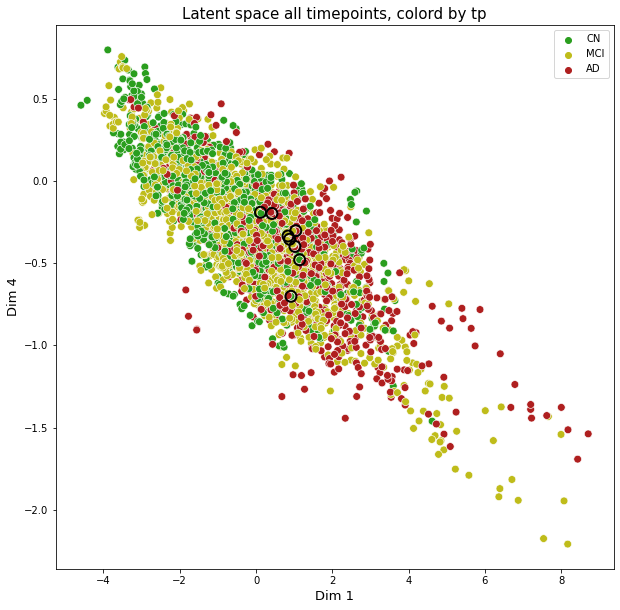

In [57]:
#3 2D Trajectory latent space visualization
dim0=1
dim1=4

#This needs to be colored by DX and AGE, and 

#plot_z_time_2d(z, max_timepoints, [dim0, dim1], out_dir, out_name='latent_space_2d')
fig, ax = plt.subplots(figsize=(10,10))
# create color cmap
colors = sns.color_palette("viridis", as_cmap=True)

#Pallete for dx
colors = sns.color_palette(["#2a9e1e", "#bfbc1a", "#af1f1f"])
# sns.set_palette(colors)

z_d0_full = []
z_d1_full = []
ptid_full = []
tp_full = []
color = []

# Create dictionary of the different labels
dx_dict = {
    "NL": "CN",
    "MCI": "MCI",
    "MCI to NL": "CN",
    "Dementia": "AD",
    "Dementia to MCI": "MCI",
    "NL to MCI": "MCI",
    "NL to Dementia": "AD",
    "MCI to Dementia": "AD"
}

for tp in range(p["ntp"]):
    train_z_d0 = [x[tp, dim0] for x in z_train if x.shape[0] > tp]
    test_z_d0 = [x[tp, dim0] for x in z_test if x.shape[0] > tp]

    train_z_d1 = [x[tp, dim1] for x in z_train if x.shape[0] > tp]
    test_z_d1 = [x[tp, dim1] for x in z_test if x.shape[0] > tp]
    
    ptid_train = [x[tp] for x in Y_train["PTID"] if x.shape[0] > tp]
    ptid_test = [x[tp] for x in Y_test["PTID"] if x.shape[0] > tp]
    
    ptid_full = ptid_full + ptid_train + ptid_test
    
    z_d0_full = z_d0_full + train_z_d0
    z_d0_full = z_d0_full + test_z_d0

    z_d1_full = z_d1_full + train_z_d1
    z_d1_full = z_d1_full + test_z_d1
    
    tp_len = len(train_z_d0) + len(test_z_d0)
    tp_full = tp_full + [tp]*tp_len

    color_train = [dx_dict[y[tp]] for (x,y) in zip(z_train, Y_train["DX"]) if x.shape[0] > tp]
    color_test = [dx_dict[y[tp]] for (x,y) in zip(z_test, Y_test["DX"]) if x.shape[0] > tp]
    
    color = color + color_train + color_test
    
print(len(z_d0_full))
print(len(z_d1_full))
print(len(color))
print(len(ptid_full))
sns.scatterplot(x=z_d0_full, y=z_d1_full, hue=color, palette=colors, s=60, ax=ax)

##Add title, x and y axis
plt.xlabel(f"Dim {dim0}", size=13)
plt.ylabel(f"Dim {dim1}", size=13)
plt.title(f"Latent space all timepoints, colord by tp", size=15)

#######################
# DECIDE HERE THE POINTS WE WANT TO SAVE
#######################

# Need to update the points alongside every latent dimension. Find a starting point, and 
#move the point alongside each one 
#New idea: find a subject in AD
# WELL FIRST LEST FINISH THE PIPELINE

ptid_to_highlight = "002_S_0295"
patient_index = [i for i, x in enumerate(ptid_full) if x == ptid_to_highlight]
print(patient_index)

#still list of one patient
patient_z0 = [z_d0_full[i] for i in patient_index]
patient_z1 = [z_d1_full[i] for i in patient_index]

plt.scatter(patient_z0, patient_z1, marker='o', color='k', facecolors='none', s=120, linewidths=2)
plt.show()

Select the points and draw over it

In [61]:
##USING PATIENT INDEX
print(len(Y_train["PTID"]))
print(len(z_train))
print(z_train[0].shape)

793
793
(8, 7)


Generate the associated sample for the points

In [ ]:
Prepare the data for brainpainter